To get a more in depth idea of how well the model performs, the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is plotted.

In [1]:
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import sys
import random

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator
test_dir = 'Neuron Cy5 Test Data'
input_size = 331

# Keras data generator to load image samples in batches
data_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True)
test_gen = data_gen.flow_from_directory(test_dir,
                                        target_size=(input_size,input_size),
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=1,
                                        shuffle=True)

classes = dict((v, k) for k, v in test_gen.class_indices.items())
num_classes = len(classes)
num_samples = len(test_gen)

Found 100 images belonging to 2 classes.


In [3]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.layers import GlobalMaxPooling2D, Dense

# Create a VGG19 architecture
pretrained_model = VGG19(include_top=False,
                         pooling='none',
                         input_shape=(input_size, input_size, 3),
                         weights=None)
x = GlobalMaxPooling2D()(pretrained_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
vgg19_model = Model(pretrained_model.input, output)

# Create new model with modified config which accepts the input shape: [input_size, input_size, 1]
cfg = vgg19_model.get_config()
cfg['layers'][0]['config']['batch_input_shape'] = (None, input_size, input_size, 1)
model = Model.from_config(cfg)

# Load in the weights from training
weights_dir = 'VGG19_weights.h5'
model.load_weights(weights_dir)

The model is then used to generate predictions on the test set and these predictions are used to give the ROC curve for each class

In [4]:
y_true = np.empty([num_samples, 2])
y_pred = np.empty([num_samples, 2])
X = np.empty([input_size, input_size, 1])

# Generate predictions on the test set
for i in range(num_samples):
    prog = ' Progress: '+str(i+1)+'/'+str(num_samples)
    X, y_true[i,:] = next(test_gen)
    y_pred[i,:] = model.predict(X, steps=1)
    sys.stdout.write('\r'+prog)
sys.stdout.write('\rDone                ')

Done                

In [5]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()

# Compute False Positive and True Positive Rates for each class
for i in range(num_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_true[:, i], y_pred[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

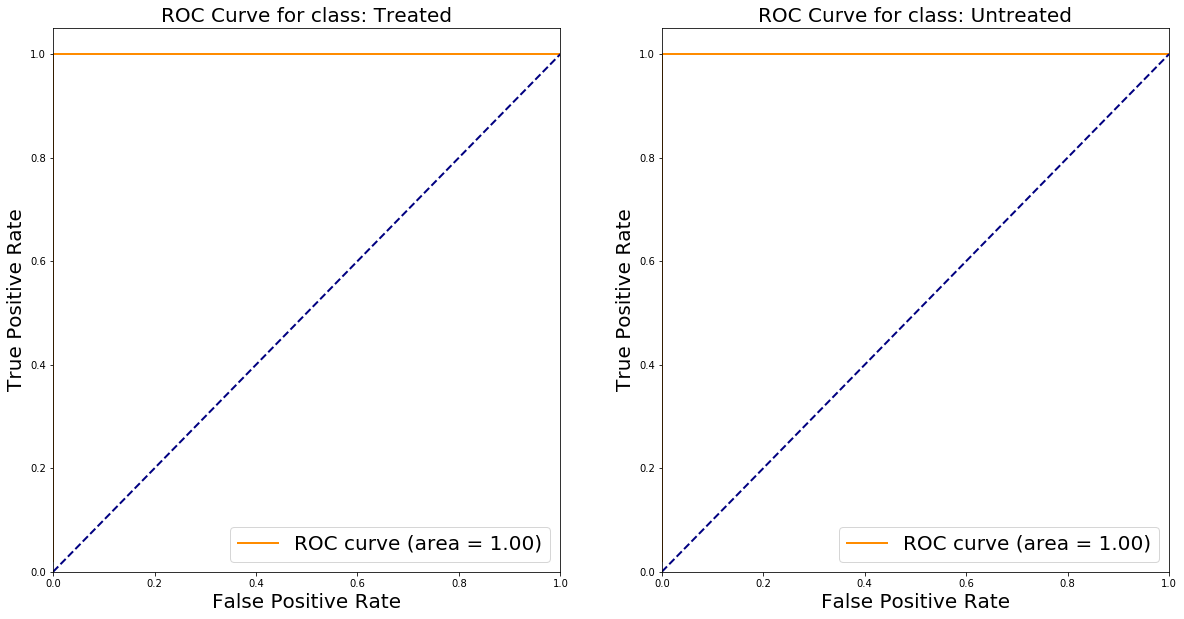

In [6]:
# Show the ROC curve for each class
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for i in range(num_classes):
    ax[i].plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    ax[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate', fontsize=20)
    ax[i].set_ylabel('True Positive Rate', fontsize=20)
    ax[i].set_title('ROC Curve for class: '+classes[i], fontsize=20)
    ax[i].legend(loc="lower right", prop={'size': 20})

Youden's J Statistic, $J = sensitivity + specificity - 1$ is the distance between the ROC curve and the "chance line" - the ROC curve of a classifier that guesses randomly.  The optimal threshold is that which maximises the J Statistic.

In [7]:
J_stats = [None]*num_classes
opt_thresholds = [None]*num_classes

# Compute Youden's J Statistic for each class
for i in range(num_classes):
    J_stats[i] = tpr[i] - fpr[i]
    opt_thresholds[i] = thresholds[i][np.argmax(J_stats[i])]
    print('Optimum threshold for '+classes[i]+': '+str(opt_thresholds[i]))

Optimum threshold for Treated: 0.7978849411010742
Optimum threshold for Untreated: 0.6298573017120361


In [8]:
# Save optimal statistics to a csv file
df = pd.DataFrame(opt_thresholds)
df.to_csv("optimum_thresholds.csv")